In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
path = "./input/"

df = pd.read_csv(path + "train.csv")
df_test = pd.read_csv(path + "test.csv")

data = pd.concat([df, df_test], sort=False)

print(df.shape)
print(df_test.shape)

(7134, 29)
(1794, 28)


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7134 entries, 0 to 7133
Data columns (total 29 columns):
Id                 7134 non-null object
groupId            7134 non-null object
matchId            7134 non-null object
assists            7134 non-null int64
boosts             7134 non-null int64
damageDealt        7134 non-null float64
DBNOs              7134 non-null int64
headshotKills      7134 non-null int64
heals              7134 non-null int64
killPlace          7134 non-null int64
killPoints         7134 non-null int64
kills              7134 non-null int64
killStreaks        7134 non-null int64
longestKill        7134 non-null float64
matchDuration      7134 non-null int64
matchType          7134 non-null object
maxPlace           7134 non-null int64
numGroups          7134 non-null int64
rankPoints         7134 non-null int64
revives            7134 non-null int64
rideDistance       7134 non-null float64
roadKills          7134 non-null int64
swimDistance       7134 n

In [56]:
# Create base line model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE

str_list =["Id", "groupId", "matchId", "matchType"]
categorical_mask = (df.dtypes == object)
categorical_columns = df.columns[categorical_mask].tolist()
print(categorical_columns)

X, y = df.drop(str_list, axis=1).iloc[:, :-1], df.iloc[:, -1]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

['Id', 'groupId', 'matchId', 'matchType']


In [4]:
# XGBoost baseline
import xgboost as xgb

xgr = xgb.XGBRegressor()
xgr.fit(X_train, y_train)
preds_xgr = xgr.predict(X_valid)

score_xgb = MAE(y_valid, preds_xgr)
print("Score with xgboost regressor:", score_xgb)

[15:05:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Score with xgboost regressor: 0.0679120909551406


In [10]:
train_DMatrix = xgb.DMatrix(data=X_train, label=y_train)
valid_DMatrix = xgb.DMatrix(data=X_valid, label=y_valid)
pubg_DMatrix = xgb.DMatrix(X, y)

params = {"objective":"reg:linear", "max_depth":4}

xgr_cv = xgb.XGBRegressor()

cv_results = xgb.cv(dtrain=train_DMatrix, params=params, nfold=5, num_boost_round=10, metrics="mae", as_pandas=True, seed=42)

# preds = xgb.predict(X_valid)

print(cv_results)
print("*****************************")
print((cv_results["test-mae-mean"]))

[15:05:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:05:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:05:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:05:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:05:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
   train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0        0.192878       0.001234       0.193364      0.005698
1        0.150147       0.001086       0.151258      0.005023
2        0.121571       0.000741       0.123136      0.004249
3        0.102160       0.000760       0.104454      0.003944
4        0.089528       0.000848       0.092363      0.003325
5        0.081437       0.000615       0.084732 

In [11]:
params = {"objective":"reg:linear", "max_depth":5}
num_rounds = [n for n in range(5, 100, 2)]
final_mae_per_round = []

# This example is not reasonable because big "num_boost_round" includes the small number of this.
for curr_num_rounds in num_rounds:

    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=pubg_DMatrix, params=params, nfold=5, num_boost_round=curr_num_rounds, metrics="mae", as_pandas=True,seed=123)

    final_mae_per_round.append(cv_results["test-mae-mean"].tail().values[-1])

num_rounds_mae = list(zip(num_rounds, final_mae_per_round))
print(pd.DataFrame(num_rounds_mae, columns=["num_boosting_rounds", "mae"]))


rror.
[15:06:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:40] WARNING: src/objective/regression_obj.cu:152: reg:linea

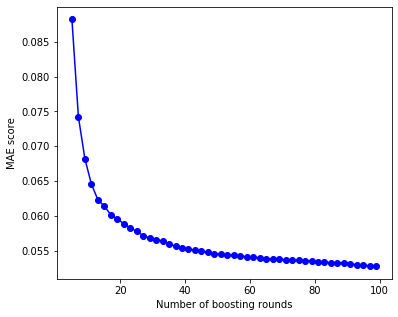

In [12]:
plt.figure(figsize=(6,5))
plt.plot(num_rounds, final_mae_per_round, "o-",color="blue")
plt.xlabel("Number of boosting rounds")
plt.ylabel("MAE score")
plt.show()

In [30]:
#Learning rate tuning
params = {"objective":"reg:linear", "max_depth":6}
eta_vals = [0.001, 0.01, 0.05, 0.1, 0.4, 0.8]

best_mae = []

# This example is not reasonable because big "num_boost_round" includes the small number of this.
for curr_val in eta_vals:

    params["eta"] = curr_val

    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=pubg_DMatrix, params=params, nfold=5, num_boost_round=100, early_stopping_rounds=6, metrics="mae", as_pandas=True,seed=123)

    best_mae.append(cv_results["test-mae-mean"].tail().values[-1])

eta_vals_mae = list(zip(eta_vals, best_mae))
print(pd.DataFrame(eta_vals_mae, columns=["eta", "best_mae"]))


[16:52:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

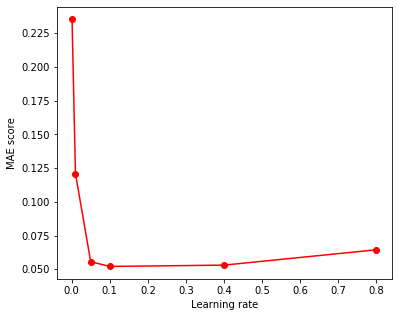

In [31]:
plt.figure(figsize=(6,5))
plt.plot(eta_vals, best_mae, "o-", color="red")
plt.xlabel("Learning rate")
plt.ylabel("MAE score")
plt.show()

In [33]:
#max depth tuning
params = {"objective":"reg:linear"}
max_depths = [2, 5, 8, 10, 15, 20, 30]

best_mae = []

# This example is not reasonable because big "num_boost_round" includes the small number of this.
for curr_val in max_depths:

    params["max_depth"] = curr_val

    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=pubg_DMatrix, params=params, nfold=5, num_boost_round=100, early_stopping_rounds=6, metrics="mae", as_pandas=True,seed=123)

    best_mae.append(cv_results["test-mae-mean"].tail().values[-1])

max_depth_mae = list(zip(max_depth, best_mae))
print(pd.DataFrame(max_depth_mae, columns=["max_depth", "best_mae"]))


[17:02:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:02:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:02:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:02:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:02:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:02:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:02:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:02:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:02:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

NameError: name 'max_depth' is not defined

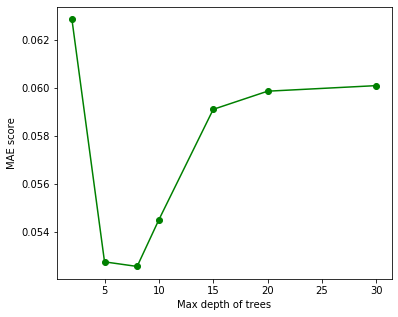

In [35]:
plt.figure(figsize=(6,5))
plt.plot(max_depths, best_mae, "o-", color="green")
plt.xlabel("Max depth of trees")
plt.ylabel("MAE score")
plt.show()

In [38]:
#colsample_bytree(max_features in scikit-learn) tuning
params = {"objective":"reg:linear"}
colsample_bytree_vals = [0.05, 0.1, 0.3, 0.6, 1]

best_mae = []

# This example is not reasonable because big "num_boost_round" includes the small number of this.
for curr_val in colsample_bytree_vals:

    params["colsample_bytree"] = curr_val

    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=pubg_DMatrix, params=params, nfold=5, num_boost_round=100, early_stopping_rounds=6, metrics="mae", as_pandas=True,seed=123)

    best_mae.append(cv_results["test-mae-mean"].tail().values[-1])

max_depth_mae = list(zip(colsample_bytree_vals, best_mae))
print(pd.DataFrame(max_depth_mae, columns=["colsample_bytree", "best_mae"]))

[17:10:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

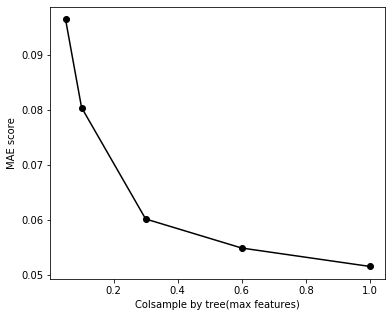

In [39]:
plt.figure(figsize=(6,5))
plt.plot(colsample_bytree_vals, best_mae, "o-", color="k")
plt.xlabel("Colsample by tree(max features)")
plt.ylabel("MAE score")
plt.show()

# GridSearch

In [46]:
from sklearn.model_selection import GridSearchCV
import time

gbm_param_grid = {
                  "colsample_bytee":[0.3, 0.7, 1],
                  "n_estimators":[80],
                  "max_depth":[2, 3, 4, 5, 6, 7, 8],
                  "eta": [0.01, 0.05, 0.1, 0.4],
                  "ealy_stopping_rounds":[8]
                  }

gbm = xgb.XGBRegressor()

grid_mae = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid, scoring="neg_mean_absolute_error", cv=4, verbose=1)

start_time = time.time()

grid_mae.fit(X, y)

elapsed_time = time.time() - start_time

print("Time: ", elapsed_time)
print("Best parameters found: ",grid_mae.best_params_)
print("Lowest MAE found: ", np.sqrt(np.abs(grid_mae.best_score_)))

eg:squarederror.
[18:18:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:18:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:18:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:18:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:18:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:18:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:18:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:18:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:19:00] WARNING: src/objective/regression_obj.cu:152

In [47]:
print("Time: ", elapsed_time)
print("Best parameters found: ",grid_mae.best_params_)
print("Lowest MAE found: ", np.abs(grid_mae.best_score_))

Time:  1103.9541618824005
Best parameters found:  {'colsample_bytee': 0.3, 'ealy_stopping_rounds': 8, 'eta': 0.001, 'max_depth': 7, 'n_estimators': 100}
Lowest MAE found:  0.05058561768062371


[17:26:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


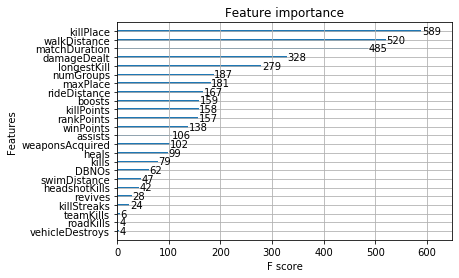

In [40]:
xg_reg = xgb.train(dtrain=pubg_DMatrix, params=params, num_boost_round=80)

X_test = df_test.drop(str_list, axis=1)
pubg_testDMatrix = xgb.DMatrix(X_test)
pubg_validDMatrix = xgb.DMatrix(X_valid)

predict_valid = xg_reg.predict(pubg_validDMatrix)
predict = xg_reg.predict(pubg_testDMatrix)

xgb.plot_importance(xg_reg)
plt.show()

In [17]:
print(MAE(predict_valid, y_valid))

0.035127778107151224


In [18]:
submission = pd.read_csv("submission.csv")
submission.head()

,winPlacePerc
0,0.160362
1,0.242487
2,0.215081
3,0.260389
4,0.552571


In [25]:
submission["winPlacePerc"] = predict
submission.to_csv("submission_xgb.csv", index=False)

In [26]:
submission_xgb = pd.read_csv("submission_xgb.csv")
submission_xgb.head()

,winPlacePerc
0,0.099776
1,0.215761
2,0.271668
3,0.270070
4,0.554272


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1aa92b70>]],
      dtype=object)

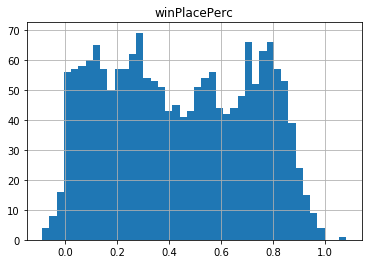

In [27]:
submission_xgb.hist(bins=int(np.sqrt(submission_xgb.shape[0])))